# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v)
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q)
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$.

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero.

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces,
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition.


# **Method**

**Define domain and mesh**

In the domain, we set the resolution = 32 to get a mesh size of h $\approx \frac{1}{32}$, and a circular hole in the middle of the domain. One local refinement is done within a radius of 1 from the circle's center in $(\frac{L}{2}, \frac{H}{2})$.

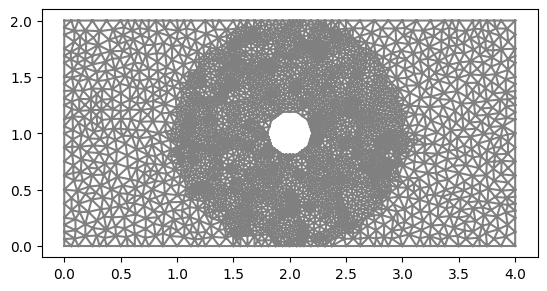

In [3]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(2.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [4]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)


# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)


**Define boundary conditions**

In [5]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

# **Solving problem using mixed elements**

**Defining and solving the variational problem using quadratic interpolation of velocity and linear interpolation of pressure**

In [6]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )


# Solve algebraic system
solve(residual == 0, w)

**Visualize the results**

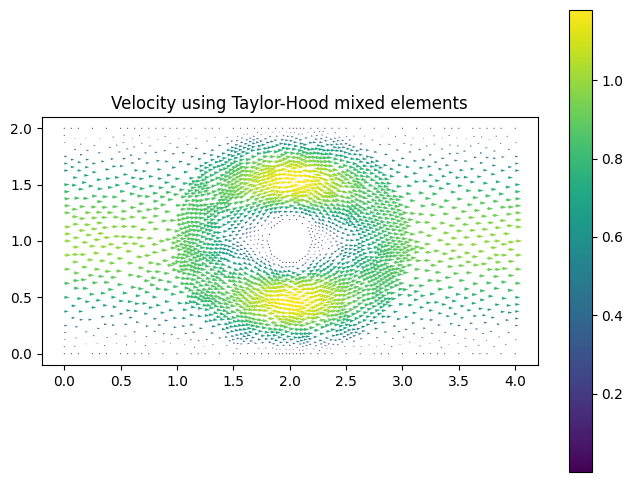

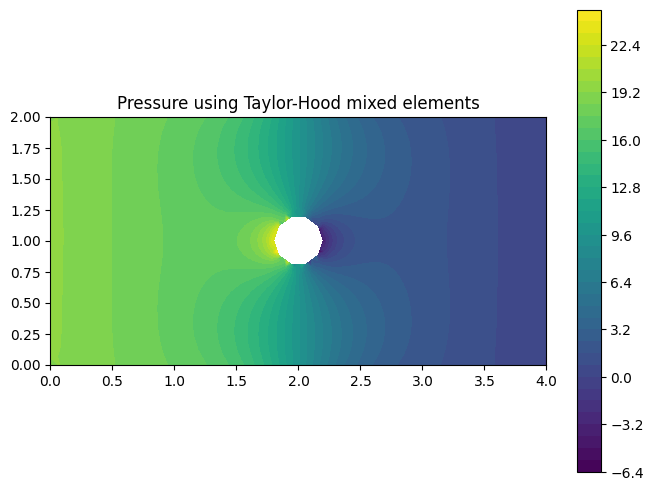

In [7]:
# projecting
u1 = project(u, V)
p1 = project(p, Q)

# plotting solution
plt.figure(figsize=(8,6))
plot1 = plot(u1, title="Velocity using Taylor-Hood mixed elements")
plt.colorbar(plot1)

plt.figure(figsize=(8,6))
plot2 =plot(p1, title="Pressure using Taylor-Hood mixed elements")
plt.colorbar(plot2)

plt.show()


As we can see in the plot, the Taylor-Hood elements are stable except for a few artefacts in pressure just at the boundary of the circular hole. These artefacts are probably due to the sharp edges and corners of the boundary of the circular hole. When tested with a in general refined mesh (i.e a smoother boundary of the hole), these artefacts did not arise.

# **Solving problem using equal order approximation**

**Define finite element approximation spaces of equal order**

In [8]:
# Generate finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 2)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)


# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# trial and test functions for stabilized version of solution
w1 = Function(W)
(u_s, p_s) = (as_vector((w1[0],w1[1])), w1[2])
(v_s, q_s) = TestFunctions(W)

**Define and solve variational problem for equal order interpolation, no stabilizer**

In [9]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )


# Solve algebraic system
solve(residual == 0, w)


# **Visualization of unstable solution**

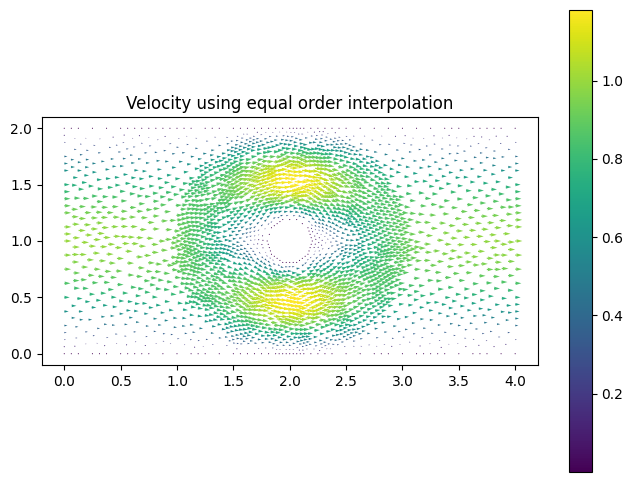

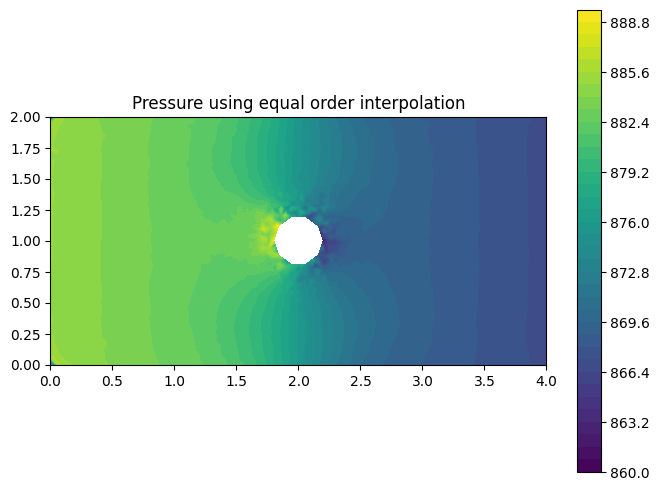

In [10]:

u1 = project(u, V)
p1 = project(p, Q)


# Plot solution
plt.figure(figsize=(8,6))
plot1 = plot(u1, title="Velocity using equal order interpolation")
plt.colorbar(plot1)

plt.figure(figsize=(8,6))
plot2 =plot(p1, title="Pressure using equal order interpolation")
plt.colorbar(plot2)


plt.show()



We can see the instabilities as oscillations around the circular hole, where the magnitude of the gradient of the pressure is larger when compared to the nearby elements. The pressure in the domain is also a lot larger when compared to the Taylor-Hood solution.







# **Define and solve variational problem using Brezzi-Pitkäranta stabilizer**

We can use a stabilizer to make the function space where pressure is approximated smaller than the velocity function space. To implement the Brezzi-Pitkäranta stabilizer, the term $C\int h^2 \nabla p \nabla q$ is added to variational form:

$-(p, \nabla v) + (\nabla u, \nabla v) + (\nabla u, q) + (Ch^2\nabla p, \nabla q) = (f, v)$,

where $C > 0$ is constant and $h$ is the average local mesh size multiplied to the term to make the pertubation smaller.

In [11]:
# stabilizer
C1 = 0.01
residual_stab = ( - p_s*div(v_s)*dx + inner(grad(u_s), grad(v_s))*dx + div(u_s)*q_s*dx + C1*h**2*inner(grad(p_s), grad(q_s))*dx
            + gamma*(ib*inner(u_s - uin, v_s) + wb*inner(u_s, v_s))*ds - inner(f, v_s)*dx )

# solve system with stabilizer
solve(residual_stab == 0, w1)


# **Visualization of stable solution**



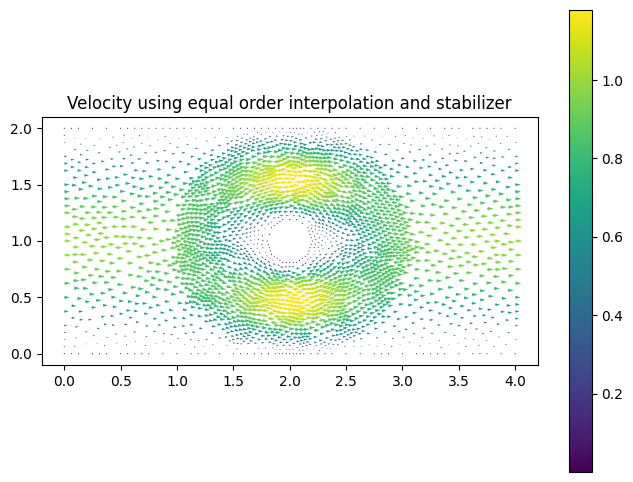

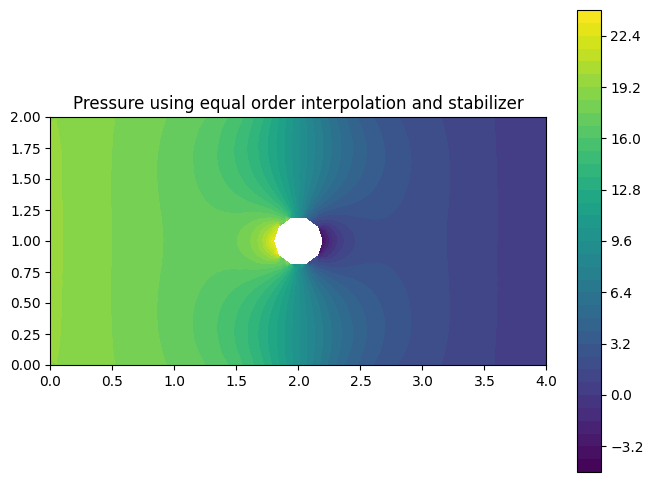

In [12]:
# stab
us = project(u_s, V)
ps = project(p_s, Q)

plt.figure(figsize=(8,6))
plot3 = plot(us, title="Velocity using equal order interpolation and stabilizer")
plt.colorbar(plot3)

plt.figure(figsize=(8,6))
plot4 = plot(ps, title="Pressure using equal order interpolation and stabilizer")
plt.colorbar(plot4)

plt.show()

In the plot for pressure, we can see the oscillations being smoothed out by the stabilizer. In this solution, C = 0.01 is used, which was chosen by trying different C and comparing the solutions. This solution in pressure looks similar to the solution when using Taylor-Hood elements above, with a similar scale of values as well. Using the stabilizer with an appropriate C, we can solve the problem with equal order interpolation.

 The results when using equal order interpolation and Brezzi-Pitkäranta stabilizer are dependent on the size of the constant C. A too small C (for example, C = 0.0001) does not smooth out oscillations around the circular hole, but the magnitude of the gradient of the pressure is not as large as in the unstable solution. This might be because the pertubation is too small and does not stabilize the solution enough. A too large C might not solve the correct problem, since a larger pertubation can change it. For example, for C = 10, the solution for the velocity also changed, and the pressure was smaller throughout the domain and varied between 0.3-12.3.



# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle in the middle of the domain, and the solution behaved as expected.  

